In [0]:
#!pip install --upgrade tables
#!pip install eli5

In [0]:
""" wczytanie bibliotek"""

import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mea
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

In [11]:
cd '/content/drive/My Drive/Colab Notebooks/DW_Matrix/matrix_two/dw_matrix_car'

/content/drive/My Drive/Colab Notebooks/DW_Matrix/matrix_two/dw_matrix_car


In [16]:
!ls

data  day2_visualization.ipynb	LICENSE  README.md


## Wczytanie danych



In [19]:
df = pd.read_hdf('data/car.h5')

df.shape

(106494, 155)

In [20]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

## Dummy Model

In [21]:
#ile kolumn o typie number
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [23]:
feats = ['car_id']

X = df [feats ].values
y = df ['price_value'].values

model = DummyRegressor()
model.fit(X,y)

y_pred = model.predict(X)

mea(y,y_pred)

39465.934630440985

In [25]:
[x for x in df.columns if 'price' in x] 

['price_currency', 'price_details', 'price_value']

In [30]:
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [31]:
#0.19 % jest w EURO
df['price_currency'].value_counts(normalize = True) * 100

PLN    99.80844
EUR     0.19156
Name: price_currency, dtype: float64

In [0]:
#usuwamy EURO
df = df [ df['price_currency'] != 'EUR' ]

## Feature


In [34]:
df['param_color'].factorize()

(array([-1, -1, -1, ..., -1, -1, -1]),
 Index(['Czarny', 'Srebrny', 'Złoty', 'Bordowy', 'Biały', 'Szary', 'Beżowy',
        'Zielony', 'Fioletowy', 'Niebieski', 'Inny kolor', 'Brązowy', 'Żółty'],
       dtype='object'))

In [0]:
SUFFIX_CAT = '__cat'
for feat in df.columns:
  if isinstance (df[feat][0],list): continue

  factorize_values = df[feat].factorize()[0]
  """ zabezpieczenie aby mozna bylo uruchomic wiwel razy komorke"""
  if SUFFIX_CAT in feat:
     df[feat] = factorize_values
  else:
    df [feat + SUFFIX_CAT] = df[feat].factorize()[0]

In [43]:
"""budujemy zbior cech"""
cat_feats = [x for x in df.columns if SUFFIX_CAT in x]

cat_feats = [x for x in cat_feats if 'price' not in x]

len(cat_feats)

151

## DecisionTreeRegressor

In [55]:
X = df [cat_feats].values

y= df ['price_value'].values

model = DecisionTreeRegressor(max_depth=5)

scores = cross_val_score(model, X,y, cv=3, scoring = 'neg_mean_absolute_error')
np.mean(scores)

-19566.588937368324

In [51]:
"""ważnosć cech """
m = DecisionTreeRegressor(max_depth=5)
m.fit (X,y)

imp = PermutationImportance(m, random_state= 0).fit(X,y)
eli5.show_weights(imp,feature_names = cat_feats)

Weight,Feature
0.2533 ± 0.0040,param_napęd__cat
0.2008 ± 0.0047,param_faktura-vat__cat
0.1943 ± 0.0088,param_stan__cat
0.1423 ± 0.0086,param_rok-produkcji__cat
0.0629 ± 0.0047,param_moc__cat
0.0424 ± 0.0014,feature_kamera-cofania__cat
0.0412 ± 0.0008,param_skrzynia-biegów__cat
0.0286 ± 0.0037,param_marka-pojazdu__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0163 ± 0.0005,feature_bluetooth__cat


In [0]:
"""funkcja pomocnicza"""

def group_and_barplot (feat_groupby , feat_agg ='price_value',agg_funcs=([np.mean,np.median,np.size]),feat_sort ='mean',top=50,subplots=True):
  return (
    df
    .groupby(feat_groupby)[feat_agg]
    .agg(agg_funcs)
    .sort_values(by =feat_sort,ascending = False)
    .head(top)
  ).plot(kind='bar',figsize = (15,5),subplots = subplots)

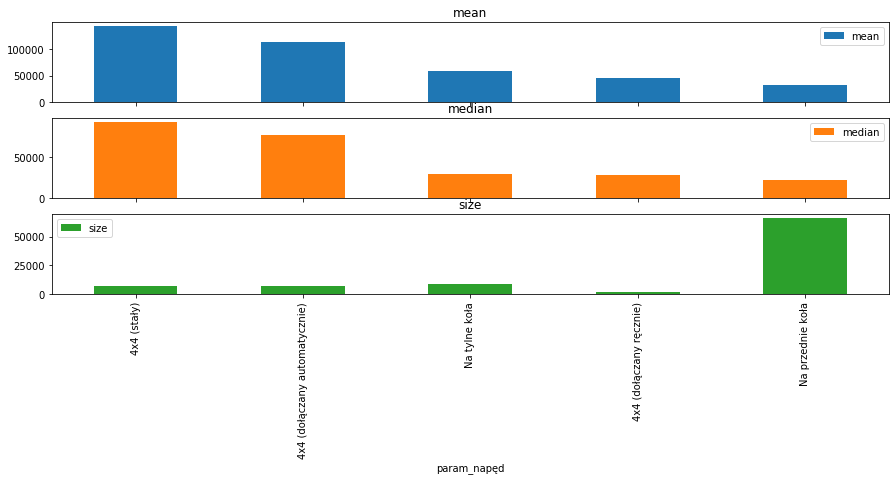

In [54]:
group_and_barplot('param_napęd');